**Charger les librairies nécéssaires**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
import os

# Change the working directory
os.chdir(r'C:\project')

**Chargement des données**

In [3]:
# Lecture du fichier nettoyé
df = pd.read_csv("data/avito_cars_clean.csv")

# Afficher les cinq premières lignes des données
df.head()

,annee,boite,carburant,kilometrage,marque,modele,nombre_portres,premiere_main,puissance_fiscale,etat,prix
0,2023,Automatique,Essence,22499.5,Alfa Romeo,Tonale,5,Oui,8,Excellent,306000
1,2018,Manuelle,Diesel,104999.5,Dacia,Duster,5,Oui,6,Excellent,155000
2,2023,Automatique,Diesel,67499.5,Hyundai,Accent,5,Oui,6,Excellent,179000
3,2023,Automatique,Diesel,22499.5,Peugeot,5008,5,Oui,8,Excellent,349000
4,2021,Automatique,Diesel,77499.5,Kia,Sportage,5,Oui,12,Très bon,685000


**ÉTAPES DE NETTOYAGE DES DONNÉES**

In [4]:
# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes:")
print(df.isnull().sum())

# Vérification des types de données
print("\nTypes de données:")
print(df.dtypes)

# Vérification des valeurs uniques pour les variables catégorielles
print("\nValeurs uniques pour les variables catégorielles:")
print("Boîte de vitesse:", df['boite'].unique())
print("Carburant:", df['carburant'].unique())
print("Marques (5 premières):", df['marque'].unique()[:5], "...")



Vérification des valeurs manquantes:
annee                0
boite                0
carburant            0
kilometrage          0
marque               0
modele               0
nombre_portres       0
premiere_main        0
puissance_fiscale    0
etat                 0
prix                 0
dtype: int64

Types de données:
annee                  int64
boite                 object
carburant             object
kilometrage          float64
marque                object
modele                object
nombre_portres         int64
premiere_main         object
puissance_fiscale      int64
etat                  object
prix                   int64
dtype: object

Valeurs uniques pour les variables catégorielles:
Boîte de vitesse: ['Automatique' 'Manuelle']
Carburant: ['Essence' 'Diesel' 'Hybride' 'Electrique' 'LPG']
Marques (5 premières): ['Alfa Romeo' 'Dacia' 'Hyundai' 'Peugeot' 'Kia'] ...


**Gestion des valeurs aberrantes pour la colonne prix**

In [5]:
print("\nDétection des valeurs aberrantes pour le prix:")
Q1 = df['prix'].quantile(0.25)
Q3 = df['prix'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
print(f"Limites pour les valeurs aberrantes: [{lower_bound}, {upper_bound}]")

# Filtrer les valeurs aberrantes
df_filtered = df[(df['prix'] >= lower_bound) & (df['prix'] <= upper_bound)]
print(f"Nombre de valeurs aberrantes supprimées: {df.shape[0] - df_filtered.shape[0]}")


Détection des valeurs aberrantes pour le prix:
Limites pour les valeurs aberrantes: [-95505.0, 332503.0]
Nombre de valeurs aberrantes supprimées: 4041


**Création d'un boxplot pour visualiser les valeurs aberrantes du prix**

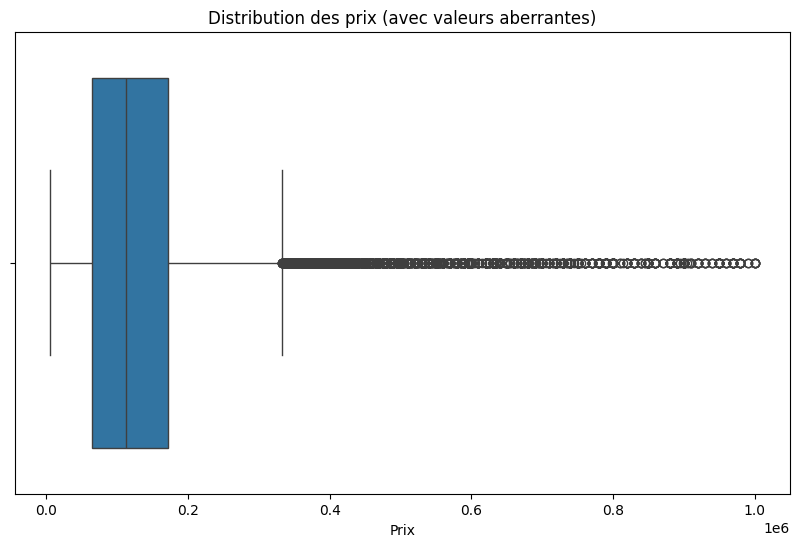

In [6]:
# Boxplot pour la colonne 'prix'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['prix'])
plt.title('Distribution des prix (avec valeurs aberrantes)')
plt.xlabel('Prix')
plt.show()
plt.close()

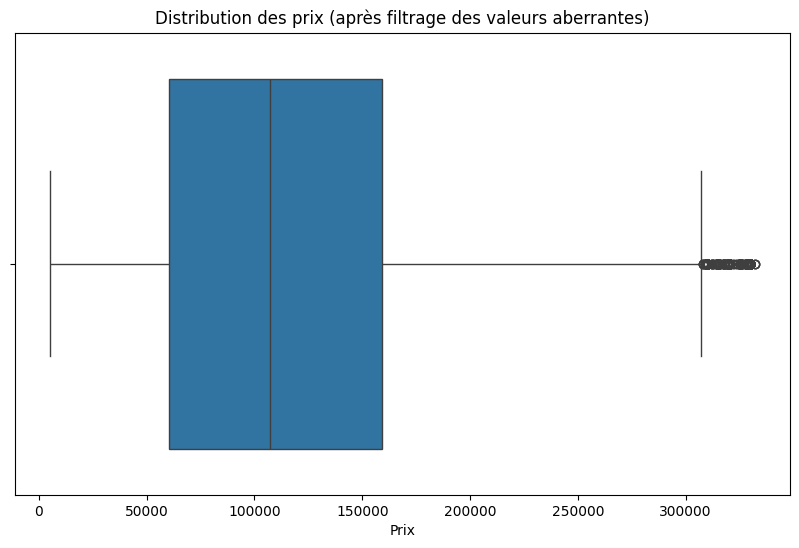

In [7]:
# Boxplot après filtrage
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_filtered['prix'])
plt.title('Distribution des prix (après filtrage des valeurs aberrantes)')
plt.xlabel('Prix')
plt.show()
plt.close()

**Préparation des données pour le modèle**

In [8]:
# Sélection des colonnes d'intérêt incluant boite et carburant
features = ['annee', 'kilometrage', 'puissance_fiscale', 'etat', 'marque', 'modele', 'boite', 'carburant', 'prix']
df_filtered = df_filtered[features]

# Encodage des variables catégorielles
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Séparation des variables explicatives (X) et de la variable cible (y)
X = df_encoded.drop("prix", axis=1)
y = df_encoded["prix"]

**Mise à l'échelle des caractéristiques numériques**

In [9]:
# Identifier les colonnes numériques
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Standardisation
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Diviser le dataset en 80% d'entraînement et 20% de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**Initialiser et entraîner le modèle Lasso**

In [11]:
print("\nInitialisation du modèle Lasso et entraînement...")

# Créer une instance du modèle Lasso
lasso = Lasso(alpha=0.1)  # alpha peut être ajusté en fonction de l'importance de la régularisation

# Entraîner le modèle Lasso sur les données d'entraînement
lasso.fit(X_train, y_train)


Initialisation du modèle Lasso et entraînement...


c:\project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e+13, tolerance: 2.605e+10
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

**Faire des prédictions**

In [12]:
# Prédire les prix sur le jeu de test
y_pred = lasso.predict(X_test)

**Évaluer les performances du modèle**

In [13]:
# Calculer les métriques d'évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
        
print("\nPerformances du modèle Lasso:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² (coefficient de détermination): {r2:.4f}")


Performances du modèle Lasso:
Mean Absolute Error (MAE): 20495.32
Root Mean Squared Error (RMSE): 31366.91
R² (coefficient de détermination): 0.8063


**Analyse des coefficients du modèle Lasso**

In [14]:
# Les coefficients non nuls montrent les caractéristiques importantes
non_zero_features = [(feature, coef) for feature, coef in zip(X.columns, lasso.coef_) if coef != 0]
sorted_features = sorted(non_zero_features, key=lambda x: abs(x[1]), reverse=True)
    
print("\nCaractéristiques les plus importantes selon Lasso:")
for feature, coef in sorted_features[:10]:  # Top 10 des caractéristiques
    print(f"{feature}: {coef:.4f}")
    
    print(f"\nNombre total de caractéristiques sélectionnées: {len(non_zero_features)} sur {len(X.columns)}")


Caractéristiques les plus importantes selon Lasso:
modele_560: 262884.8708

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_Classe G: 262270.4125

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_Allante: 259327.0460

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_Karman: 226681.4106

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_403: 214929.0210

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_2 CV: 168059.7512

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_260: 148904.0355

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_Rekord: 141685.2643

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_Regata: 140415.1285

Nombre total de caractéristiques sélectionnées: 773 sur 852
modele_131: 132774.7590

Nombre total de caractéristiques sélectionnées: 773 sur 852


**Visualisation des résultats**

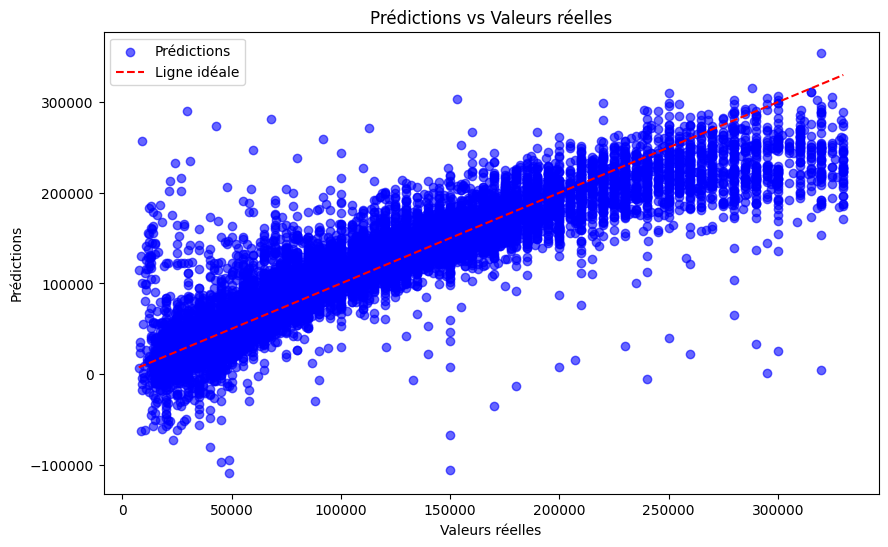

In [15]:
# Prédiction vs Valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Prédictions', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ligne idéale', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.legend()
plt.show()

C:\Users\ss\AppData\Local\Temp\ipykernel_15264\812287913.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


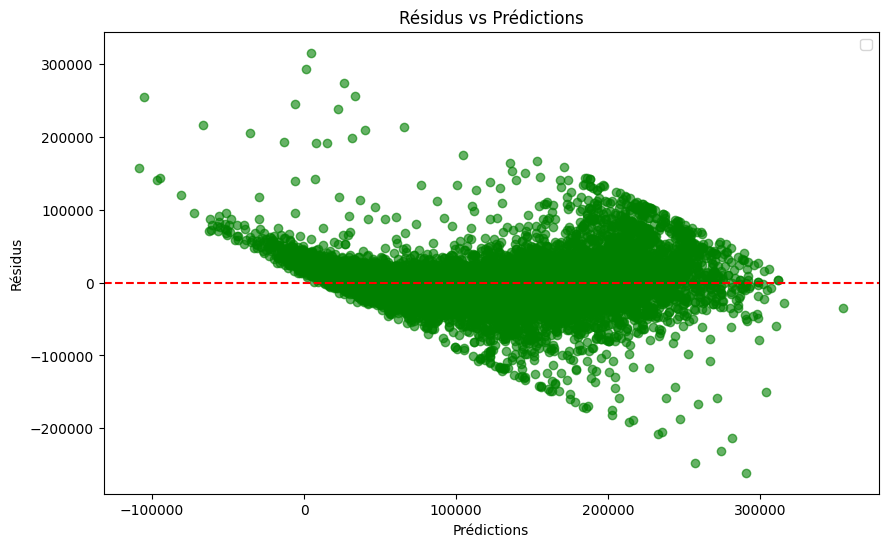

In [16]:
# Tracer les résidus
residus = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residus, color='green', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Résidus vs Prédictions')
plt.legend()
plt.show()

In [17]:
import joblib

# Sauvegarder le scaler
joblib.dump(scaler, 'pkl-files/lasso_scaler.pkl')

# Sauvegarder le modèle
joblib.dump(lasso, 'pkl-files/lasso_model.pkl')

# Sauvegarder les colonnes utilisées dans le modèle
joblib.dump(X.columns, 'pkl-files/lasso_columns.pkl')

print("Le scaler et le modèle de la regression Lasso ont été sauvegardés sous forme de fichiers .pkl.")

Le scaler et le modèle de la regression Lasso ont été sauvegardés sous forme de fichiers .pkl.
